In [1]:
import pandas as pd
from utils.data_loader import load_data

df, config, features = load_data()

In [2]:
cutoffs = {
    "ALL": 0.4528432,
    "AML": 0.5001304,
    "APL": 0.3770665
}

# Define the prediction columns
prediction_columns = [f"prediction.{cat}" for cat in ["ALL", "AML", "APL"]]

# Calculate the max prediction value and corresponding class
df["max_pred_value"] = df[prediction_columns].max(axis=1)
df["max_pred_class"] = df[prediction_columns].idxmax(axis=1).str.replace("prediction.", "", regex=False)

# Check if the max prediction value is above the cutoff for the corresponding class
df["above_cutoff"] = df.apply(
    lambda row: row["max_pred_value"] >= cutoffs[row["max_pred_class"]],
    axis=1
)

# Count the number of deleted samples
deleted_count = len(df[~df["above_cutoff"]])

# Filter the DataFrame to keep only the samples above the cutoff
df = df[df["above_cutoff"]]

# Clean up temporary columns
df.drop(columns=["max_pred_value", "max_pred_class", "above_cutoff"], inplace=True)

In [3]:
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import classification_report, confusion_matrix

df.columns

y_true = df['class']
y_pred = df[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1]) 
f1_score(y_true, y_pred, average='weighted')
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ALL       0.94      0.61      0.74      1274
         AML       0.19      0.61      0.29       173
         APL       0.10      0.53      0.17        17

    accuracy                           0.61      1464
   macro avg       0.41      0.58      0.40      1464
weighted avg       0.84      0.61      0.68      1464

[[772 440  62]
 [ 46 106  21]
 [  3   5   9]]


Classification Report for Outlier Detection:
              precision    recall  f1-score   support

         ALL       0.95      0.66      0.78       996
         AML       0.15      0.60      0.24        92
         APL       0.03      0.20      0.05         5

    accuracy                           0.65      1093
   macro avg       0.38      0.49      0.36      1093
weighted avg       0.88      0.65      0.73      1093

Confusion Matrix:
[[658 314  24]
 [ 30  55   7]
 [  2   2   1]]


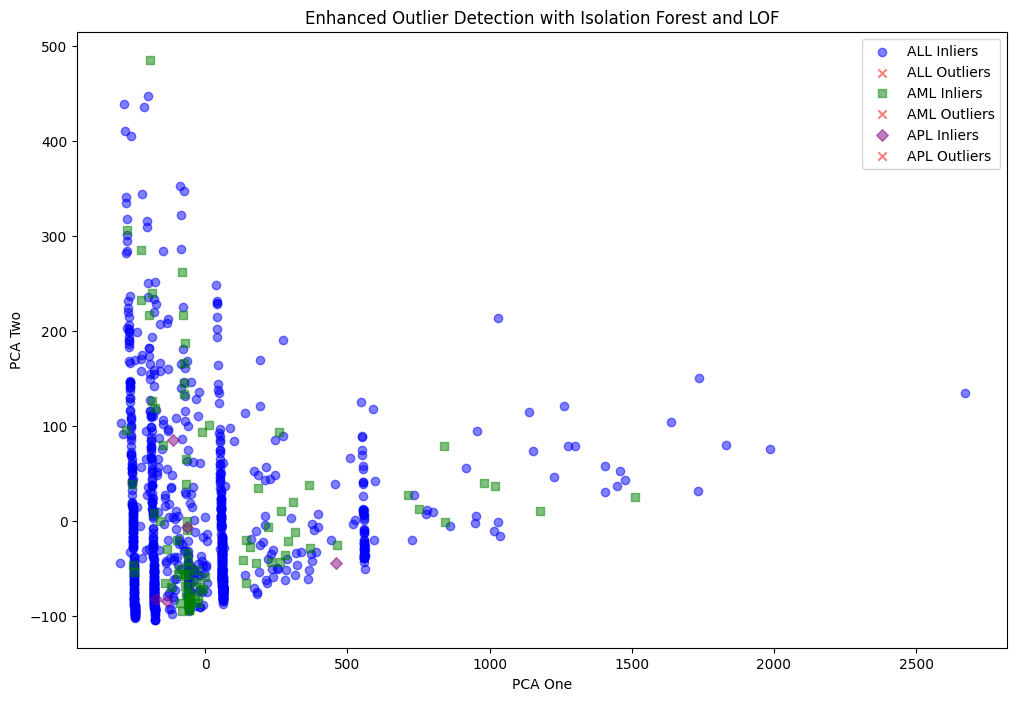

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# Load your data
data = df.copy()

# Define features and handle missing values with imputation
features = ["age", "MCV_fL", "PT_percent", "LDH_UI_L", "MCHC_g_L", 
            "WBC_G_L", "Fibrinogen_g_L", "Monocytes_G_L", 
            "Platelets_G_L", "Lymphocytes_G_L", "Monocytes_percent"]

# Impute missing values (e.g., using median for each feature)
imputer = SimpleImputer(strategy="median")
data_cleaned = data.copy()
data_cleaned[features] = imputer.fit_transform(data[features])

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data_cleaned['outlier_iso'] = iso_forest.fit_predict(data_cleaned[features])

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20)
data_cleaned['outlier_lof'] = lof.fit_predict(data_cleaned[features])

# Combine the outlier detections
data_cleaned['outlier'] = ((data_cleaned['outlier_iso'] == -1) | (data_cleaned['outlier_lof'] == -1)).astype(int)

# Known labels
data_cleaned = data_cleaned[data_cleaned['outlier'] == 0]
y_true = data_cleaned['class']
y_pred = data_cleaned[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])

# Evaluation
print("Classification Report for Outlier Detection:")
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_cleaned[features])
data_cleaned['pca_one'] = pca_result[:, 0]
data_cleaned['pca_two'] = pca_result[:, 1]

# Plot the results with labels
plt.figure(figsize=(12, 8))

# Plot each class with distinct colors for outliers and inliers
for class_label, color, marker in zip(['ALL', 'AML', 'APL'], ['blue', 'green', 'purple'], ['o', 's', 'D']):
    subset = data_cleaned[data_cleaned['class'] == class_label]
    # Inliers
    plt.scatter(subset.loc[subset['outlier'] == 0, 'pca_one'], 
                subset.loc[subset['outlier'] == 0, 'pca_two'], 
                color=color, marker=marker, label=f'{class_label} Inliers', alpha=0.5)
    # Outliers
    plt.scatter(subset.loc[subset['outlier'] == 1, 'pca_one'], 
                subset.loc[subset['outlier'] == 1, 'pca_two'], 
                color='red', marker='x', label=f'{class_label} Outliers', alpha=0.5)

plt.title('Enhanced Outlier Detection with Isolation Forest and LOF')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.legend()
plt.show()

/home/merengelke/.cache/pypoetry/virtualenvs/aipal-validation-aTJd2GXG-py3.10/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Classification Report for Outlier Detection:
              precision    recall  f1-score   support

         ALL       0.94      0.64      0.76      1000
         AML       0.22      0.59      0.32       152
         APL       0.12      0.56      0.19        16

    accuracy                           0.63      1168
   macro avg       0.42      0.60      0.43      1168
weighted avg       0.83      0.63      0.70      1168

Confusion Matrix:
[[642 310  48]
 [ 41  90  21]
 [  2   5   9]]


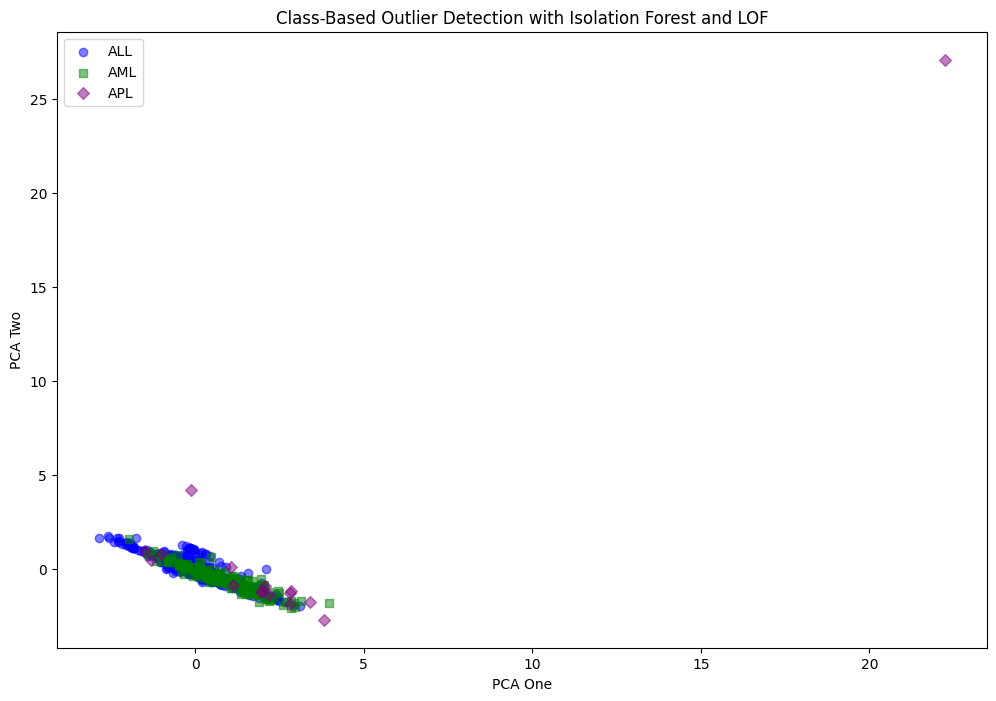

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load your data
data = df.copy()

# Reset the index to ensure there are no duplicate labels
data = data.reset_index(drop=True)

# Define features and handle missing values with imputation
features = ["age", "MCV_fL", "PT_percent", "LDH_UI_L", "MCHC_g_L", 
            "WBC_G_L", "Fibrinogen_g_L", "Monocytes_G_L", 
            "Platelets_G_L", "Lymphocytes_G_L", "Monocytes_percent"]

# Impute missing values (e.g., using median for each feature)
imputer = SimpleImputer(strategy="median")
data_cleaned = data.copy()
data_cleaned[features] = imputer.fit_transform(data[features])

# Standardize features
scaler = StandardScaler()
data_cleaned[features] = scaler.fit_transform(data_cleaned[features])

# Apply Isolation Forest and Local Outlier Factor per class
outliers = pd.Series([0] * len(data_cleaned), index=data_cleaned.index)
for class_label in data_cleaned['class'].unique():
    # Select data for the current class and preserve the original index
    class_data = data_cleaned[data_cleaned['class'] == class_label]
    original_index = class_data.index  # Keep the index for alignment

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_outliers = iso_forest.fit_predict(class_data[features])

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20)
    lof_outliers = lof.fit_predict(class_data[features])

    # Combine the outlier detections within each class
    combined_outliers = pd.Series(
        ((iso_outliers == -1) | (lof_outliers == -1)).astype(int),
        index=original_index  # Ensure index alignment
    )
    
    # Assign outliers to the main Series using aligned indices
    outliers.loc[original_index] = combined_outliers

# Remove detected outliers and reset the index
data_cleaned['outlier'] = outliers
data_cleaned = data_cleaned[data_cleaned['outlier'] == 0].reset_index(drop=True)

# Known labels and predictions
y_true = data_cleaned['class']
y_pred = data_cleaned[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])

# Evaluate performance
print("Classification Report for Outlier Detection:")
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_cleaned[features])
data_cleaned['pca_one'] = pca_result[:, 0]
data_cleaned['pca_two'] = pca_result[:, 1]

# Plot the results with class-based inliers and outliers
plt.figure(figsize=(12, 8))
for class_label, color, marker in zip(['ALL', 'AML', 'APL'], ['blue', 'green', 'purple'], ['o', 's', 'D']):
    subset = data_cleaned[data_cleaned['class'] == class_label]
    plt.scatter(subset['pca_one'], 
                subset['pca_two'], 
                color=color, marker=marker, label=f'{class_label}', alpha=0.5)

plt.title('Class-Based Outlier Detection with Isolation Forest and LOF')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.legend()
plt.show()